# Wine Quality

## Goal

We're going to create a Python function that exports train/test dataloaders with a specified quality threshold for binarizing bad/good. Original data has unbalanced data of wine quality from 1 to 6. We're going to binarize this data in couple of different ways to see how balancing is important.

## Data

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from scipy import stats
import seaborn as sns

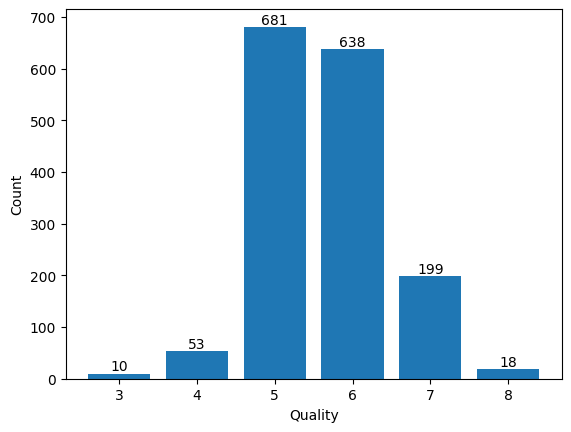

In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',
                 sep = ';')
columns2zscore = df.drop('quality', axis = 1).columns
df[columns2zscore] = df[columns2zscore].apply(stats.zscore)
x = df['quality'].value_counts().keys()
y = df['quality'].value_counts().values
plt.bar(x,y)
for x_, y_ in zip(x,y):
  plt.text(x_, y_, f'{y_:.0f}', ha = 'center', va = 'bottom')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

This data is completely unbalanced, before feeding this data to deep learning model we would need to binarize it. Question is how we should binarize it? In this experiment we're going to binarize it in 3 ways, out of which 2 will be unbalanced and 1 balanced.

## Quality Binarize

In [ ]:
def create_dataset(qual_threshold):
  tmp = (df['quality']>qual_threshold).astype(int)
  df['bool_quality'] = tmp

  dataT = torch.tensor(df[columns2zscore].values).float()
  labelsT = torch.tensor(df['bool_quality'].values).float()
  labelsT = labelsT[:,None]

  train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size = .2)

  train_dataset = TensorDataset(train_data, train_labels)
  test_dataset = TensorDataset(test_data, test_labels)

  batch_size = 9
  train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
  test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

  return train_dataloader, test_dataloader

In [ ]:
train_dataloader, test_dataloader = create_dataset(qual_threshold = 5)

quality_ratings = train_dataloader.dataset.tensors[1].detach()
print('Quality rating 5')
print(f'Train Low Quality: {sum(quality_ratings == 0)}')
print(f'Train High Quality: {sum(quality_ratings == 1)}')

Quality rating 5
Train Low Quality: tensor([599])
Train High Quality: tensor([680])


## Model Arch

In [ ]:
class ModelArch(nn.Module):
  def __init__(self):
    super().__init__()

    # input
    self.input = nn.Linear(11, 16)

    # hidden
    self.fc1 = nn.Linear(16, 32)
    self.fc2 = nn.Linear(32, 32)

    # output
    self.output = nn.Linear(32, 1)

  # forward pass
  def forward(self, x):

    x = self.input(x)
    x = F.relu(x)

    # hidden layer 1
    x = self.fc1(x)   # weighted combination
    x = F.relu(x)     # activation function

    # hidden layer 2
    x = self.fc2(x)# weighted combination
    x = F.relu(x)

    x = self.output(x)

    return x

## Model Setup

In [ ]:
def ModelSetup():
  ann = ModelArch()
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(ann.parameters(), lr = 1e-3)

  return ann, loss_fn, optimizer

In [ ]:
ann, loss_fn, optimizer = ModelSetup()
X, y = next(iter(train_dataloader))
temp_data = torch.randn(10, 11)
temp_y_hat = ann(X)
temp_y_hat

tensor([[-0.1552],
        [-0.1518],
        [-0.1645],
        [-0.1502],
        [-0.1474],
        [-0.1516],
        [-0.1466],
        [-0.1505],
        [-0.1352]], grad_fn=<AddmmBackward0>)

## Model Train

In [ ]:
def ModelTrain(epochs, verbose = True):
  ann, loss_fn, optimizer = ModelSetup()

  losses = torch.zeros(epochs)

  train_accs = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)

  for epoch in range(epochs):
    ann.train()

    batch_accs = torch.zeros(len(train_dataloader))
    batch_losses = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):

      batch_y_hat = ann(X_train)

      loss = loss_fn(batch_y_hat, y_train)
      batch_losses[batch] = loss

      acc = 100 * torch.mean(
          ( (batch_y_hat > 0) == y_train ).float()
      )
      batch_accs[batch] = acc

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    losses[epoch] = torch.mean(batch_losses)
    train_accs[epoch] = torch.mean(batch_accs)

    # test accuracy
    ann.eval()
    X_test, y_test = next(iter(test_dataloader))
    with torch.no_grad():
      test_y_hat = ann(X_test)
    test_acc = 100 * torch.mean(
        ( (test_y_hat > 0) == y_test ).float()
    )
    test_accs[epoch] = test_acc

    if epoch % 10 == 0 and verbose:
      print(f'Epoch {epoch} | Loss: {torch.mean(batch_losses):2f} | Train Acc: {torch.mean(batch_accs):2f} | Test Acc: {test_acc:2f}')

  return train_accs, test_accs, losses, ann

## Experiment

Test

In [ ]:
train_dataloader, test_dataloader = create_dataset(qual_threshold = 5)
train_accs, test_accs, losses, ann = ModelTrain(10)

Epoch 0 | Loss: 0.658935 | Train Acc: 61.149960 | Test Acc: 73.437500


Experiment

PROCESSING QUALITY THRESHOLD: 3
PROCESSING QUALITY THRESHOLD: 4
PROCESSING QUALITY THRESHOLD: 5
PROCESSING QUALITY THRESHOLD: 6
PROCESSING QUALITY THRESHOLD: 7
PROCESSING QUALITY THRESHOLD: 8


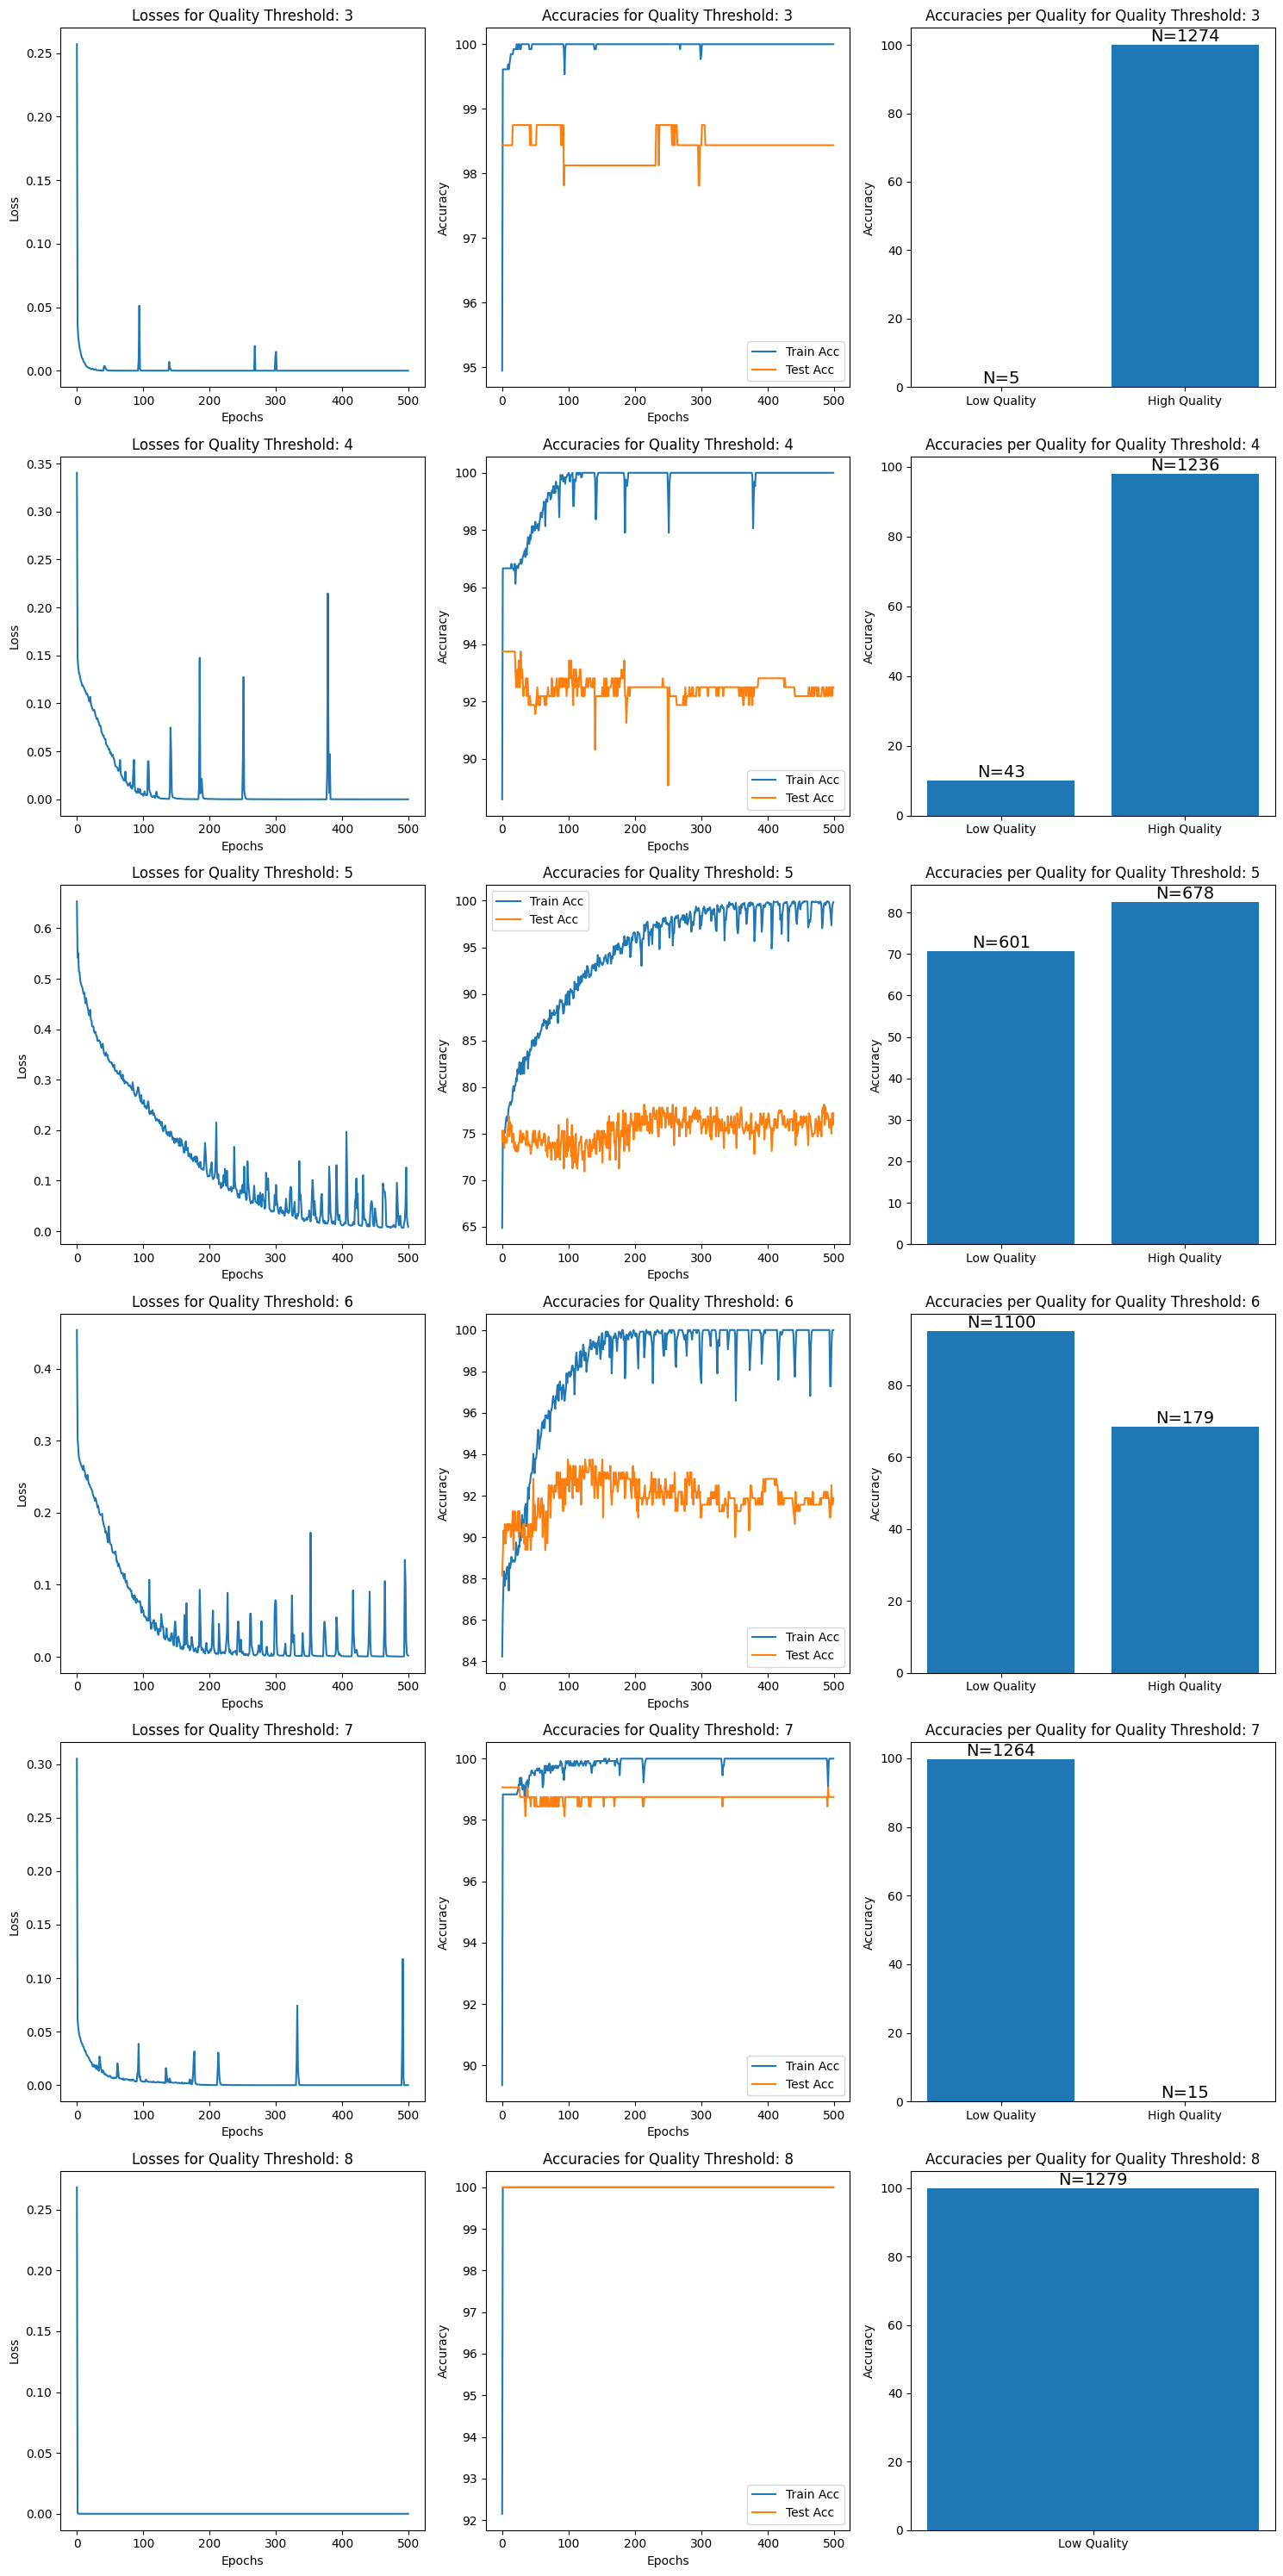

In [34]:
quality_thresholds = np.arange(df['quality'].min(), df['quality'].max() + 1)
epochs = 500

fig, axs = plt.subplots(len(quality_thresholds), 3,figsize = (15, len(quality_thresholds) * 5) )
title = 'Quality Threshold: '

results = torch.zeros((len(quality_thresholds), epochs, 3))
per_qual_accs = {}

for i, qt in enumerate(quality_thresholds):
  print(f'PROCESSING QUALITY THRESHOLD: {qt}')
  train_dataloader, test_dataloader = create_dataset(qual_threshold = qt)
  train_accs, test_accs, losses, ann = ModelTrain(epochs, verbose = False)

  # Test
  X, y = next(iter(test_dataloader))
  y_hat = ann(X)
  correct_preds = ((y_hat > 0) == y).float()
  per_qual_acc = [
      100 * torch.mean(correct_preds[y == 0]),
      100 * torch.mean(correct_preds[y == 1])
  ]

  # METRICS
  results[i,:,0] = losses
  results[i,:,1] = train_accs
  results[i,:,2] = test_accs

  per_qual_accs[qt] = per_qual_acc

  # PLOTS
  axs[i,0].plot(results[i,:,0].detach())
  axs[i,0].set_ylabel('Loss')
  axs[i,0].set_xlabel('Epochs')
  axs[i,0].set_title(f'Losses for Quality Threshold: {quality_thresholds[i]}')

  axs[i,1].plot(results[i,:,1].detach(), label = 'Train Acc')
  axs[i,1].plot(results[i,:,2].detach(), label = 'Test Acc')
  axs[i,1].set_xlabel('Epochs')
  axs[i,1].set_ylabel('Accuracy')
  axs[i,1].set_title(f'Accuracies for Quality Threshold: {quality_thresholds[i]}')
  axs[i,1].legend()

  bh = axs[i,2].bar(['Low Quality', 'High Quality'], list(per_qual_accs.values())[i])
  axs[i,2].set_title(f'Accuracies per Quality for Quality Threshold: {quality_thresholds[i]}')
  axs[i,2].set_ylabel('Accuracy')

  for j, r in enumerate(bh):
    N = torch.sum(train_dataloader.dataset.tensors[1] == j).item()
    axs[i, 2].text(
        r.get_x() + r.get_width()/2,
        r.get_height(),
        f'N={N}',
        ha='center',
        va='bottom',
        fontsize=14
    )

plt.tight_layout()
plt.show()

## Conclusion

As we can see, the more unbalanced our dataset is, the greater the bias becomes. The model tends to overfit to the oversampled category.

An interesting observation can be made in the first two and the last plots (with quality thresholds of 3, 4, and 8). At first glance, they show almost perfect accuracy — but there’s a catch. The issue lies in the fact that there are almost no samples from the second class.

Imagine we have 99 images of cats and only one image of a dog. Do we really need a model to achieve 99% accuracy? Not really — a trivial model that always predicts “cat” would still reach that accuracy. That’s essentially what happens here: because one category is heavily oversampled, the model can simply keep predicting that category and appear highly accurate, even though it hasn’t actually learned meaningful distinctions.

This illustrates why having balanced data is crucial when training a model. High accuracy doesn’t always mean good learning — especially when the dataset itself is skewed.